# Sugestão de metodologia para cálculo de Intervalos de Confiança 

Conforme mencionado na LDO de 2018, o modelo oficial do governo se define como determinístico: 

“[...] *ou seja, a partir da fixação de um conjunto de variáveis, o modelo determina de maneira única seus resultados* [...]

Como se trabalha com probabilidades, não necessariamente todos os eventos previstos podem acontecer. O modelo da LDO é determinístico por trabalhar apenas com médias (ex: média de pessoas que se aposentarão) e não considera diferentes cenários onde isso pode não ocorrer, ou seja, situações diferentes do comportamento médio.

Este documento busca apresentar uma forma diferente de se projetar estoques considerando diferentes cenários onde nem sempre os segurados irão se aposentar.

In [203]:
import sys
sys.path.insert(0, '../')

from util.tabelas import LerTabelas
import modelos.fazenda as fz


###################### Parâmetros de simulação ###############################

# Período de projeção 
periodo = list(range(2015, 2061))

# Ano de referência para cálculo das probabilidades
ano_probabilidade = 2014

#############################################################################

arquivo = '../dados/dados_fazenda.xlsx'

# Abri o arquivo
dados = LerTabelas(arquivo)

# Beneficio que será avaliado
id_aptcn = 'AtcnUrbPisoH'

# Lista de Ids dos beneficios
ids_estoques = dados.get_id_beneficios([], 'Es')
ids_concessoes = dados.get_id_beneficios([], 'Co')
ids_cessacoes = dados.get_id_beneficios([], 'Ce')

# Obtem as tabelas e armazena nos dicionários correspondentes
estoques = dados.get_tabelas(ids_estoques)
concessoes = dados.get_tabelas(ids_concessoes)
cessacoes = dados.get_tabelas(ids_cessacoes)
populacao = dados.get_tabelas(dados.ids_pop_ibge)
populacao_pnad = dados.get_tabelas(dados.ids_pop_pnad)



In [204]:
# Calcula taxas de urbanização, participação e ocupação
taxas = fz.calc_taxas(populacao_pnad, periodo)

# Calcula: Pop Urbana|Rural, PEA e Pop Ocupada, Contribuintes e Segurados Rurais
segurados = fz.calc_demografia(populacao, taxas)

# Calcula as probabilidades de entrada em benefício e morte
probabilidades = fz.calc_probabilidades(populacao, segurados, estoques,
                                     concessoes, cessacoes, periodo)



Problemas nas probabilidades

Tabela: ApinRurH
IDADE
85    2.0
86    2.0
88    2.0
dtype: float64
_________________

Tabela: ApinRurM
IDADE
88    2.0
90    2.0
dtype: float64
_________________

Tabela: ApinUrbAcimH
IDADE
87    2.0
88    2.0
89    2.0
dtype: float64
_________________

Tabela: ApinUrbAcimM
IDADE
83    2.0
84    2.0
87    2.0
88    2.0
dtype: float64
_________________

Tabela: AtcnUrbAcimH
IDADE
87    2.0
dtype: float64
_________________

Tabela: AtcnUrbAcimM
IDADE
83    2.0
84    2.0
dtype: float64
_________________

Tabela: AinvRurH
IDADE
85    2.0
86    2.0
dtype: float64
_________________

Tabela: AinvRurM
IDADE
88    2.0
90    2.0
dtype: float64
_________________

Tabela: AinvUrbAcimH
IDADE
87    2.0
88    2.0
dtype: float64
_________________

Tabela: AinvUrbAcimM
IDADE
83    2.0
84    2.0
87    2.0
88    2.0
dtype: float64
_________________

Tabela: AuxdRurH
IDADE
15    2.0
dtype: float64
_________________

Tabela: AuxdRurM
IDADE
15    2.0
90    2.0
dtype: float64
_

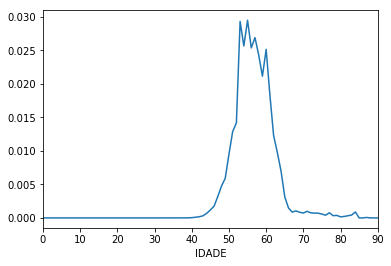

In [205]:
probabilidades[id_aptcn].plot();

In [206]:
# Cria a função que calcula o estoque usando as equações da LDO
def calc_estoq_apos(est, conc, prob, seg, periodo):
    
    # Calcula somente para a Aposentadoria por Tempo de Contribuição
    ids_apos= ['AtcnUrbPisoH']

    # Cria o objeto dados que possui os IDs das tabelas
    dados = LerTabelas()

    # Obtem as aposentadorias para todas as clientelas e sexos
    lista_benef = dados.get_id_beneficios(ids_apos)
        
    for benef in lista_benef:
        # Verifica se o beneficio existe no Estoque
        if benef in est:
        
            sexo = benef[-1]                # Obtém o Sexo
            id_prob_morte = 'Mort'+ sexo    # ex: MortH
            id_fam = 'fam'+benef            # fator de ajuste de mortalidade            
            id_segurado = dados.get_id_segurados(benef)  # ex: CsmUrbH
            
            for ano in periodo:                
                # Adiciona uma nova coluna (ano) no DataFrame com valores zero
                est[benef][ano] = 0
                
                # 1 a 90 anos - Equação 11 da LDO de 2018
                for idade in range(1,91): 
                    est_ano_anterior = est[benef][ano-1][idade-1]
                    prob_sobreviver = 1 - prob[id_prob_morte][ano][idade] * prob[id_fam][idade]
                    entradas = seg[id_segurado][ano][idade] * prob[benef][idade]
                    # Eq. 11
                    est[benef].loc[idade, ano] = est_ano_anterior * prob_sobreviver + entradas     # Eq. 11
                    # Salva a quantidade de concessões para uso posterior
                    conc[benef].loc[idade,ano] = entradas
                
                # Calculo para a idade zero
                est[benef].loc[0, ano] = seg[id_segurado][ano][0] * prob[benef][0]
                # Salva a quantidade de concessões para uso posterior
                conc[benef].loc[0, ano] = est[benef].loc[0, ano]
                
                # Ajuste para a idade de 90+ anos (modelo UFPA) - REVISAR
                est[benef].loc[90, ano] = est[benef].loc[90, ano] + est[benef].loc[90, ano - 1]
                

    return est

# Executa a função
est_deterministico = calc_estoq_apos(estoques, concessoes, probabilidades, segurados, periodo)

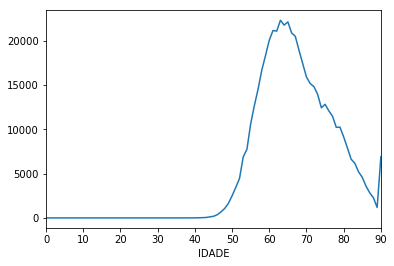

In [207]:
est_deterministico[id_aptcn][2015].plot();


In [208]:
list(range(0,30))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]